<a href="https://colab.research.google.com/github/Tony363/Chartmetric_Analysis/blob/master/Chartmetric_DataConsolidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [330]:
   """
    forcasting followers and listeners over 6 month regression
    model around followers and listeners
    cut off followers lower than 10000
    cut off listeners 100000
    popularity cut off 40
    
    *create new metric(artist score) off of populurity,followers, listeners <- these 3 variables
    homepage and dashboard(UI)
    step 1 <- visual representation of what the platform looks like (basic sustainable platform)
      - barebones UI
      - with plot metrics
    -heursticals timeseries giving it a weights average and aggregate
      (proof of concept first)<-small easy project easy money
    - diff var / value mean
    - pair xy regressor    
    * continue with logistic regression
    """

'\n forcasting followers and listeners over 6 month regression\n model around followers and listeners\n cut off followers lower than 10000\n cut off listeners 100000\n popularity cut off 40\n \n *create new metric(artist score) off of populurity,followers, listeners <- these 3 variables\n homepage and dashboard(UI)\n step 1 <- visual representation of what the platform looks like (basic sustainable platform)\n   - barebones UI\n   - with plot metrics\n -heursticals timeseries giving it a weights average and aggregate\n   (proof of concept first)<-small easy project easy money\n - diff var / value mean\n - pair xy regressor    \n * continue with logistic regression\n '

model around followers and listeners


In [331]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec  4 13:24:30 2020

@author: tony
"""

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler,StandardScaler,RobustScaler
from scipy import stats  
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools

# load in main database of songs and attributes
def load_data():
    df = pd.read_csv("Chartmetric_Sample_Data.csv")
    df.drop('Unnamed: 0',axis=1,inplace=True)
    df.set_index("Chartmetric_ID",inplace=True)
    return df

# set some display options so easier to view all columns at once
def set_view_options(max_cols=50, max_rows=50, max_colwidth=9, dis_width=250):
    pd.options.display.max_columns = max_cols
    pd.options.display.max_rows = max_rows
    pd.set_option('max_colwidth', max_colwidth)
    pd.options.display.width = dis_width
    
def rename_columns(df):
    subidx = [df.columns.get_loc(col) for col in df.columns if "Subject" in col] 
    subjects = df.columns[[subidx]]
    df.rename(columns={df.columns[subidx[idx]]:df.iloc[0,subidx[idx]] for idx,sub in enumerate(subidx)},inplace=True)
    for subject,idx in enumerate(range(0,len(df.columns),7)):
        df.rename(columns={sub:df.columns[subidx[subject]]+" "+sub for idx,sub in enumerate(df.columns[idx+1:idx+7])},inplace=True)
    return df

def get_df_info(df):
    # print memory usage
    print(df.memory_usage(),'\n')
    # take an initial look at our data
    print(df.head(),'\n')

    # take a look at the columns in our data set
    print("The columns are:")
    print(df.columns,'\n')

    # look at data types for each
    info = df.info()
    print(info,'\n')

    # take a look at data types, and it looks like we have a pretty clean data set!
    # However, I think the 0 popularity scores might throw the model(s) off a bit.
    print("Do we have any nulls?")
    print(f"Looks like we have {df.isnull().sum().sum()} nulls\n")
    
    subject_col = []
    statsdf = []
    # look at basic metric mapping
    for idx,col in enumerate(df.columns):
        if idx % 7 != 0:
            try:
                stats = df.agg({col:['min','max','median','mean','skew']})
                subject_col.append(col)
                statsdf.append(stats.transpose())
            except Exception as e:
                # print(e)
                continue
    statsdf = pd.concat(statsdf,axis=0,ignore_index=True)
    statsdf.set_index([pd.Index(subject_col)],inplace=True)
    return statsdf
    # print(df.agg({col:['min','max','median','skew'] for idx,col in enumerate(df.columns) if idx % 7 != 0}))

# calculate and print more stats from the df
def get_stats(df):
    df.reset_index(inplace=True)
    # print stats for various metrics
    print()
    print(f"There are {df.shape[0]} rows")
    print(f"There are {df['Chartmetric_ID'].unique().shape} unique artists")
    print(f"There are {df['popularity value.1'].unique().shape} unique popularity scores")
    print(f"The mean popularity score is {df['popularity value.1'].mean()}")
    print(f"There are {df[df['popularity value.1'] > 55]['popularity value.1'].count()} songs with a popularity score > 55")
    print(f"There are {df[df['popularity value.1'] > 75]['popularity value.1'].count()} songs with a popularity score > 75")
    print(f"Only {(df[df['popularity value.1'] > 80]['popularity value.1'].count() / df.shape[0])*100:.2f} % of artists have a popularity score > 80")
    
def group_time(df):
    timeidx = [df.columns.get_loc(col) for col in df.columns if "timestp" in col] 
    time = df.iloc[:,timeidx]
    time = time.reset_index().drop('Chartmetric_ID',axis=1).loc[:,'followers timestp']
    df = df.drop(df.columns[timeidx[1:]],axis=1).reset_index().groupby(['followers timestp'])[['Chartmetric_ID','followers value','popularity value.1','listeners value.2','followers_to_listeners_ratio value.3']].first()
    df.fillna(df.mean(),inplace=True)
    df['fx followers'] = df['followers value'].pct_change()
    df['fx popularity'] = df['popularity value.1'].pct_change()
    df['fx listeners'] = df['listeners value.2'].pct_change()
    df['fx ratio'] = df['followers_to_listeners_ratio value.3'].pct_change()
    df_std = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Chartmetric_ID','followers value','popularity value.1','listeners value.2','followers_to_listeners_ratio value.3'],axis=1)),columns=['fx followers','fx popularity','fx listeners','fx ratio'])
    df_std['time series'] = time
    df_std.set_index('time series',inplace=True)
    df_norm = pd.DataFrame(MinMaxScaler().fit_transform(df.drop(['Chartmetric_ID','followers value','popularity value.1','listeners value.2','followers_to_listeners_ratio value.3'],axis=1)),columns=['fx followers','fx popularity','fx listeners','fx ratio'])
    df_norm['time series'] = time
    df_norm.set_index('time series',inplace=True)
    df_std_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_std),columns=['fx followers','fx popularity','fx listeners','fx ratio'])
    return df.drop(['fx followers','fx popularity','fx listeners','fx ratio'],axis=1),df_std,df_norm,df_std_norm

def artist_diff_metric(df):
    timeidx = [df.columns.get_loc(col) for col in df.columns if "timestp" in col] 
    valueidx = [df.columns.get_loc(col) for col in df.columns if "value" in col] 
    df.drop(df.columns[timeidx+valueidx],axis=1,inplace=True)
    df.reset_index(inplace=True)
    artist_unique_row = [df.groupby('Chartmetric_ID').groups[artist][0] for artist in df.groupby('Chartmetric_ID').groups]
    df = df.loc[artist_unique_row,:].drop(['followers','popularity','listeners'],axis=1).set_index('Chartmetric_ID')
    return df

def Multivariable_Matrix(df,col):
    cmatrix = []
    for shift in range(df.shape[0]):
        cseries = df.loc[:,col].shift(-shift)
        smatrix = pd.DataFrame({f'{col}_shift_{shift}':cseries.values})
        cmatrix.append(smatrix)
    cmatrix = pd.concat(cmatrix,axis=1)
    return cmatrix
    
def calc_correlations(df, cutoff=0.5):
    corr = df.corr()
    corr_data = corr[corr > cutoff]
    corr_list = df.corr().unstack().sort_values(kind="quicksort",ascending=False)
    return corr_list.drop(corr_list.index[:20]),corr_data

# nice way to truncate the column names to display easier
# can be used with various metrics
def describe_cols(df, L=10):
    '''Limit ENTIRE column width (including header)'''
    # get the max col width
    O = pd.get_option("display.max_colwidth")
    # set max col width to be L
    pd.set_option("display.max_colwidth", L)
    describe = df.rename(columns=lambda x: x[:L - 2] + '...' if len(x) > L else x).describe()
    pd.set_option("display.max_colwidth", O) 
    return describe

# get redundant pairs from DataFrame
def get_redundant_pairs(df):
    '''Get diagonal pairs of correlation matrix and all pairs we'll remove 
    (since pair each is doubled in corr matrix)'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            if df[cols[i]].dtype != 'object' and df[cols[j]].dtype != 'object':
                # print("THIS IS NOT AN OBJECT, YO, so you CAN take a corr of it, smarty!")
                pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    print("The top absolute correlations are:")
    print(au_corr[0:n])
    return au_corr[0:n]
    
# plot a scatter plot
def scatter_plot(df, col_x, col_y):
    plt.scatter(df[col_x], df[col_y], alpha=0.2)
    plt.title(f"{col_x} vs {col_y}")
    plt.xlabel(f"{col_x}")
    plt.ylabel(f"{col_y}")
    plt.show()

def plot_scatter_matrix(df, num_rows):
    scatter_matrix(df[:num_rows], alpha=0.2, figsize=(6, 6), diagonal='kde')
    plt.show()

# plot a heatmap of the correlations between features as well as dependent variable
def plot_heatmap(df):
    # note this looks better in jupyter as well
    plt.figure(figsize = (16,6))
    sns.heatmap(df.corr(), cmap="coolwarm", annot=True, )
    plt.show()
  
# plot a confusion matrix
def plot_confusion_matrix(cm, ax, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    font_size = 24
    p = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=font_size)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=16)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=16)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 1 and j == 1:
            lbl = "(True Positive)"
        elif i == 0 and j == 0:
            lbl = "(True Negative)"
        elif i == 1 and j == 0:
            lbl = "(False Negative)"
        elif i == 0 and j == 1:
            lbl = "(False Positive)"
        ax.text(j, i, "{:0.2f} \n{}".format(cm[i, j], lbl),
                 horizontalalignment="center", size = font_size,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    ax.set_ylabel('True',fontsize=font_size)
    ax.set_xlabel('Predicted',fontsize=font_size)
    
# plot polularity scores distribution
def plot_pop_dist(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.distplot(df['popularity value.1']/100, color='g', label="Popularity").set_title("Distribution of Popularity Scores - Entire Data Set")

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")

    plt.show()

# plot undersampling methodology
def undersample_plot(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.distplot(df['popularity value.1']/100, color='g', label="Popularity").set_title("Illustration of Undersampling from Data Set")
    
    # create line to shade to the right of
    line = ax.get_lines()[-1]
    x_line, y_line = line.get_data()
    mask = x_line > 0.55
    x_line, y_line = x_line[mask], y_line[mask]
    ax.fill_between(x_line, y1=y_line, alpha=0.5, facecolor='red')

    # get values for and plot first label
    label_x = 0.5
    label_y = 4
    arrow_x = 0.6
    arrow_y = 0.2

    arrow_properties = dict(
        facecolor="black", width=2,
        headwidth=4,connectionstyle='arc3,rad=0')

    plt.annotate(
        "First, sample all songs in this range.\n Sample size is n. Cutoff is 0.5.", xy=(arrow_x, arrow_y),
        xytext=(label_x, label_y),
        bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.5),
        arrowprops=arrow_properties)

    # Get values for and plot second label
    label_x = 0.1
    label_y = 3
    arrow_x = 0.2
    arrow_y = 0.2

    arrow_properties = dict(
        facecolor="black", width=2,
        headwidth=4,connectionstyle='arc3,rad=0')

    plt.annotate(
        "Next, randomly sample \n n songs in this range", xy=(arrow_x, arrow_y),
        xytext=(label_x, label_y),
        bbox=dict(boxstyle='round,pad=0.5', fc='g', alpha=0.5),
        arrowprops=arrow_properties)

    # plot final word box
    plt.annotate(
        "Therefore, end up with a 50/50 \n split of Popular / Not Popular\n songs", xy=(0.6, 2),
        xytext=(0.62, 2),
        bbox=dict(boxstyle='round,pad=0.5', fc='b', alpha=0.5))

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")

    plt.show()

# plot univariate dists for several independent variables
def plot_univ_dists(df, cutoff):
    popularity_cutoff = cutoff
    print('Mean value for followers feature for Popular artists: {}'.format(df[df['popularity value.1'] > popularity_cutoff]['followers value'].mean()))
    print('Mean value for followers feature for Unpopular artists: {}'.format(df[df['popularity value.1'] < popularity_cutoff]['followers value'].mean()))
    print('Mean value for listeners feature for Popular artists: {}'.format(df[df['popularity value.1'] > popularity_cutoff]['listeners value.2'].mean()))
    print('Mean value for listeners feature for Unpopular artists: {}'.format(df[df['popularity value.1'] < popularity_cutoff]['listeners value.2'].mean()))
  
    
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    fig.suptitle('Histograms and Univariate Distributions of Important Features')
    sns.distplot(df[df['popularity value.1'] < popularity_cutoff]['followers value'])
    sns.distplot(df[df['popularity value.1'] > popularity_cutoff]['followers value'])
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.distplot(df[df['popularity value.1'] < popularity_cutoff]['listeners value.2'])
    sns.distplot(df[df['popularity value.1'] > popularity_cutoff]['listeners value.2'])
    plt.show()

# choose cutoff, sample popular data, randomly sample unpopular data, and combine the dfs
def split_sample_combine(df, cutoff=55, col='popularity', rand=None):
    # split out popular rows above the popularity cutoff
    split_pop_df = df[df[col] > cutoff].copy()
    
    # get the leftover rows, the 'unpopular' songs
    df_leftover = df[df[col] < cutoff].copy()
    
    # what % of the original data do we now have?
    ratio = split_pop_df.shape[0] / df.shape[0]
    
    # what % of leftover rows do we need?
    ratio_leftover = split_pop_df.shape[0] / df_leftover.shape[0]
    
    # get the exact # of unpopular rows needed, using a random sampler
    unpop_df_leftover, unpop_df_to_add = train_test_split(df_leftover, \
                                                          test_size=ratio_leftover, \
                                                          random_state = rand)
    
    # combine the dataframes to get total rows = split_pop_df * 2
    # ssc stands for "split_sample_combine"
    ssc_df = split_pop_df.append(unpop_df_to_add).reset_index(drop=True)

    # shuffle the df
    ssc_df = ssc_df.sample(frac=1, random_state=rand).reset_index(drop=True)
    
    # add key_notes mapping key num vals to notes
    key_mapping = {0.0: 'C', 1.0: 'C♯,D♭', 2.0: 'D', 3.0: 'D♯,E♭', 
                   4.0: 'E', 5.0: 'F', 6.0: 'F♯,G♭', 7.0: 'G', 
                   8.0: 'G♯,A♭', 9.0: 'A', 10.0: 'A♯,B♭', 11.0: 'B'}
    ssc_df['key_notes'] = ssc_df['key'].map(key_mapping)
    
    # add columns relating to popularity
    ssc_df['pop_frac'] = ssc_df['popularity'] / 100
    ssc_df['pop_cat'] = np.where(ssc_df['popularity'] > cutoff, "Popular", "Not_Popular")
    ssc_df['pop_bin'] = np.where(ssc_df['popularity'] > cutoff, 1, 0)
    
    return ssc_df

# initial linear regression function, and plots
def linear_regression_initial(df):
    df = df.copy()
    for col in df.columns:
        X_cols = df.columns.drop(col)
    
        y_col = [col]
    
        X = df[X_cols]
        y = df[y_col]
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
        X_train = sm.add_constant(X_train)
    
        # Instantiate OLS model, fit, predict, get errors
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        fitted_vals = results.predict(X_train)
        stu_resid = results.resid_pearson
        residuals = results.resid
        y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals, \
                               'stu_resid': stu_resid})
    
        # Print the results
        print(results.summary())
    
        # QQ Plot
        fig, ax = plt.subplots(figsize=(8, 5))
        plt.title(f"QQ Plot-{col} Initial Linear Regression")
        fig = sm.qqplot(stu_resid, line='45', fit=True, ax=ax)
        plt.show()
    
        # Residuals Plot
        y_vals.plot(kind='scatter', x='fitted_vals', y='stu_resid')
        plt.title(f"{col} regression")
        plt.show()
        
# Create a basic logistic regression
def basic_logistic_regression(df, cutoff=55, rand=0, sig_only=False):
    df = df.copy()

    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=80, rand=rand))
        X = standardize_X(X)

    X_const = add_constant(X, prepend=True)

    logit_model = Logit(y, X_const).fit()
    
    print(logit_model.summary())

    return logit_model

# various data standardization and X/y split functions for logisitic reression
# based on the columns you want to standardize and return
def return_X_y_logistic(df):
    df = df.copy()

    # define columns to use for each
    X_cols = df.columns

    # use 1's and 0's for logistic
    y_col = df.columns[0]

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

def return_X_y_logistic_sig_only(df):
    df = df.copy()

    # define columns to use for each
    X_cols = ['danceability','energy', 
              'instrumentalness', 'loudness']

    # use 1's and 0's for logistic
    y_col = ['pop_bin']

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

def standardize_X(X):  
    X = X.copy()
    
    # standardize only columns not between 0 and 1
    for col in cols_to_standardize:
        new_col_name = col + "_std"
        X[new_col_name] = (X[col] - X[col].mean()) / X[col].std()
        
    X_cols = ['acousticness', 'danceability', 'duration_ms_std', 'energy', 
                  'instrumentalness', 'key', 'liveness', 'loudness_std', 'mode', 
                  'speechiness', 'tempo_std', 'time_signature', 'valence']

    # return the std columns in a dataframe
    X = X[X_cols]
    
    return X

def standardize_X_sig_only(X):  
    X = X.copy()
    
    cols = ['loudness']
    # standardize only columns not between 0 and 1
    for col in cols:
        new_col_name = col + "_std"
        X[new_col_name] = (X[col] - X[col].mean()) / X[col].std()
        
    X_cols = ['danceability','energy', 
              'instrumentalness', 'loudness_std']

    # return the std columns in a dataframe
    X = X[X_cols]
    
    return X

def logistic_regression_with_kfold(df, cutoff=55, rand=0, sig_only=False):
    df = df.copy()
    
    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X(X)

    X = X.values
    y = y.values.ravel()

    classifier = LogisticRegression()

    # before kFold
    y_predict = classifier.fit(X, y).predict(X)
    y_true = y
    accuracy_score(y_true, y_predict)
    print(f"accuracy: {accuracy_score(y_true, y_predict)}")
    print(f"precision: {precision_score(y_true, y_predict)}")
    print(f"recall: {recall_score(y_true, y_predict)}")
    print(f"The coefs are: {classifier.fit(X,y).coef_}")

    # with kfold
    kfold = KFold(len(y))

    accuracies = []
    precisions = []
    recalls = []

    for train_index, test_index in kfold:
        model = LogisticRegression()
        model.fit(X[train_index], y[train_index])

        y_predict = model.predict(X[test_index])
        y_true = y[test_index]

        accuracies.append(accuracy_score(y_true, y_predict))
        precisions.append(precision_score(y_true, y_predict))
        recalls.append(recall_score(y_true, y_predict))

    print(f"accuracy: {np.average(accuracies)}")
    print(f"precision: {np.average(precisions)}")
    print(f"recall: {np.average(recalls)}")


In [332]:
# data clean
df = load_data()  
set_view_options(max_cols=50, max_rows=50, max_colwidth=40, dis_width=250)
duplicated = True in df.columns.duplicated()
print(f"duplicate columns: {duplicated}\n")
df = rename_columns(df)
df.fillna(df.mean(),inplace=True)
grp,grp_std,grp_norm,grp_stdnorm = group_time(df)


duplicate columns: False



/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [333]:
# without normalization or standization
grp

,Chartmetric_ID,followers value,popularity value.1,listeners value.2,followers_to_listeners_ratio value.3
followers timestp,,,,,
2020-01-01T00:00:00.000Z,Lyrycyst,509.0,3.0,190.0,267.89
2020-01-02T00:00:00.000Z,Sam & Dave,180028.0,61.0,1462956.0,12.31
2020-01-03T00:00:00.000Z,Lyrycyst,509.0,3.0,187.0,272.19
2020-01-04T00:00:00.000Z,Sam & Dave,180274.0,62.0,1477611.0,12.20
2020-01-05T00:00:00.000Z,Lyrycyst,508.0,3.0,193.0,263.21
...,...,...,...,...,...
2020-05-28T00:00:00.000Z,Sam & Dave,196209.0,60.0,1675737.0,11.71
2020-05-29T00:00:00.000Z,Sam & Dave,196209.0,60.0,1675737.0,11.71
2020-05-30T00:00:00.000Z,Sam & Dave,196890.0,60.0,1704301.0,11.55


In [334]:
# standardized percent change 
grp_std

,fx followers,fx popularity,fx listeners,fx ratio
time series,,,,
2020-01-02T00:00:00.000Z,NaN,NaN,NaN,NaN
2020-01-04T00:00:00.000Z,1.281164,2.331276,2.098025,-0.513887
2020-01-08T00:00:00.000Z,-0.369903,-0.508622,-0.379410,3.263469
2020-01-10T00:00:00.000Z,1.283420,2.377945,2.162986,-0.514081
2020-01-14T00:00:00.000Z,-0.369903,-0.508733,-0.379410,3.171591
...,...,...,...,...
2020-01-11T00:00:00.000Z,-0.365248,-0.375502,-0.379089,-0.350564
2020-01-13T00:00:00.000Z,-0.365248,-0.375502,-0.379089,-0.350564
2020-01-15T00:00:00.000Z,-0.365232,-0.375502,-0.379083,-0.352903


In [335]:
# normalized percent change
grp_norm

,fx followers,fx popularity,fx listeners,fx ratio
time series,,,,
2020-01-02T00:00:00.000Z,NaN,NaN,NaN,NaN
2020-01-04T00:00:00.000Z,0.410420,0.615814,5.923591e-01,0.000351
2020-01-08T00:00:00.000Z,0.000002,0.000586,3.908557e-09,0.969530
2020-01-10T00:00:00.000Z,0.410981,0.625924,6.078912e-01,0.000302
2020-01-14T00:00:00.000Z,0.000002,0.000562,4.123417e-09,0.945957
...,...,...,...,...
2020-01-11T00:00:00.000Z,0.001159,0.029425,7.692614e-05,0.042256
2020-01-13T00:00:00.000Z,0.001159,0.029425,7.692614e-05,0.042256
2020-01-15T00:00:00.000Z,0.001163,0.029425,7.823749e-05,0.041656


In [336]:
# standardized then normalized percent change
grp_stdnorm

,fx followers,fx popularity,fx listeners,fx ratio
0,NaN,NaN,NaN,NaN
1,0.410420,0.615814,5.923591e-01,0.000351
2,0.000002,0.000586,3.908557e-09,0.969530
3,0.410981,0.625924,6.078912e-01,0.000302
4,0.000002,0.000562,4.123417e-09,0.945957
...,...,...,...,...
148,0.001159,0.029425,7.692614e-05,0.042256
149,0.001159,0.029425,7.692614e-05,0.042256
150,0.001163,0.029425,7.823749e-05,0.041656
151,0.001159,0.029425,7.692614e-05,0.042256


In [337]:
# unique artist difference df
artist_diff = artist_diff_metric(df)
artist_diff

,followers weekly_diff,followers weekly_diff_percent,followers monthly_diff,followers monthly_diff_percent,popularity weekly_diff.1,popularity weekly_diff_percent.1,popularity monthly_diff.1,popularity monthly_diff_percent.1,listeners weekly_diff.2,listeners weekly_diff_percent.2,listeners monthly_diff.2,listeners monthly_diff_percent.2,followers_to_listeners_ratio,followers_to_listeners_ratio weekly_diff.3,followers_to_listeners_ratio weekly_diff_percent.3,followers_to_listeners_ratio monthly_diff.3,followers_to_listeners_ratio monthly_diff_percent.3
Chartmetric_ID,,,,,,,,,,,,,,,,,
20syl,229.0,0.2300,844.0,0.8528,0.0,0.0,0.0,0.0000,2.0,0.0005,-10314.0,-2.7009,followers_to_listeners_ratio,0.000614,0.229106,0.009464,3.651967
21 Savage,21294.0,0.2467,60223.0,0.7008,0.0,0.0,-1.0,-1.0870,-1117492.0,-5.0836,755915.0,3.7591,followers_to_listeners_ratio,0.022052,5.615783,-0.012595,-2.947398
3 Um Só,919.0,0.4898,3979.0,2.1559,0.0,0.0,0.0,0.0000,-877.0,-1.4909,-5141.0,-8.1489,followers_to_listeners_ratio,0.064132,2.010682,0.328212,11.219063
311,2006.0,0.3026,8028.0,1.2223,0.0,0.0,0.0,0.0000,-57382.0,-2.6298,-103150.0,-4.6303,followers_to_listeners_ratio,0.009149,3.011749,0.018093,6.136694
4Minute,2497.0,0.3009,10040.0,1.2208,0.0,0.0,0.0,0.0000,-4480.0,-0.8333,-20107.0,-3.6342,followers_to_listeners_ratio,0.017655,1.143680,0.074890,5.038124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xilent,94.0,0.1941,359.0,0.7452,0.0,0.0,0.0,0.0000,-933.0,-0.8264,-1855.0,-1.6298,followers_to_listeners_ratio,0.004415,1.029018,0.010219,2.414435
Yazoo,1703.0,0.5158,6492.0,1.9950,0.0,0.0,1.0,1.6667,-22525.0,-1.4294,-48525.0,-3.0294,followers_to_listeners_ratio,0.004135,1.973389,0.010525,5.180952
Young Disciples,53.0,0.6231,140.0,1.6629,0.0,0.0,0.0,0.0000,-388.0,-1.2375,-1857.0,-5.6576,followers_to_listeners_ratio,0.005111,1.883969,0.019903,7.759545


Index                                   1224
Chartmetric_ID                          1224
followers value                         1224
popularity value.1                      1224
listeners value.2                       1224
followers_to_listeners_ratio value.3    1224
dtype: int64 

                         Chartmetric_ID  followers value  popularity value.1  listeners value.2  followers_to_listeners_ratio value.3
followers timestp                                                                                                                    
2020-01-01T00:00:00.000Z       Lyrycyst            509.0                 3.0              190.0                                267.89
2020-01-02T00:00:00.000Z     Sam & Dave         180028.0                61.0          1462956.0                                 12.31
2020-01-03T00:00:00.000Z       Lyrycyst            509.0                 3.0              187.0                                272.19
2020-01-04T00:00:00.000Z     Sam & Dave      

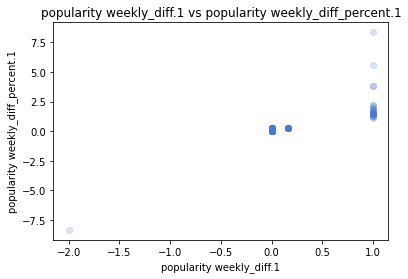

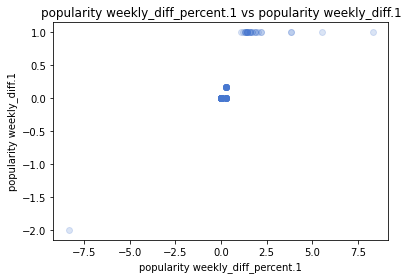

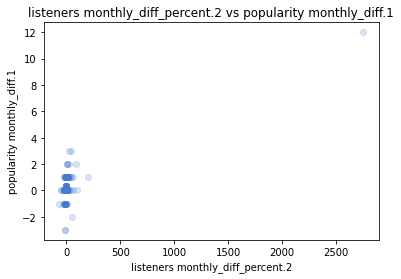

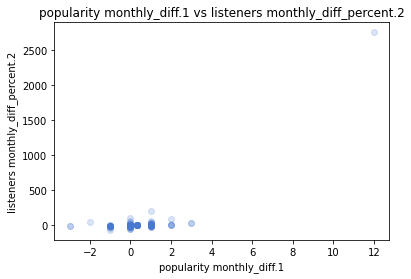

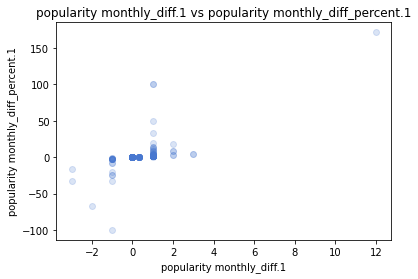

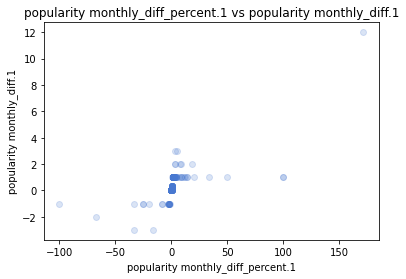

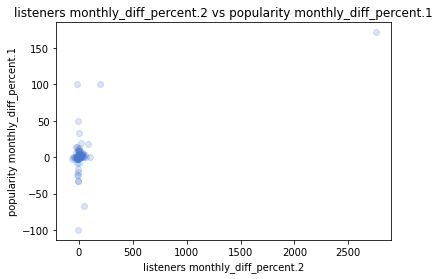

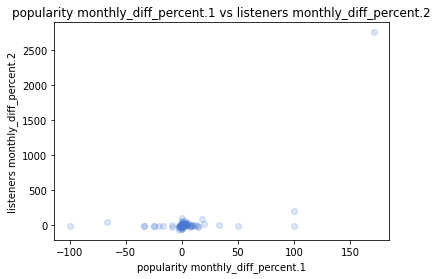

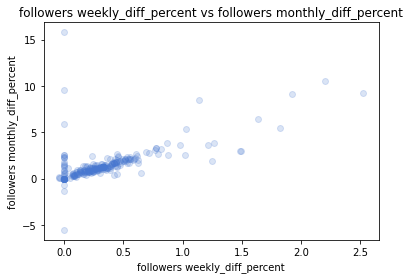

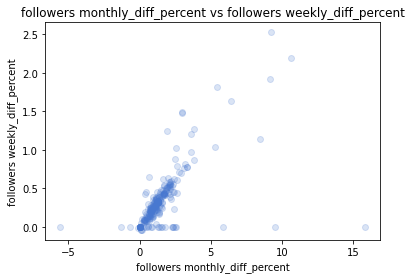

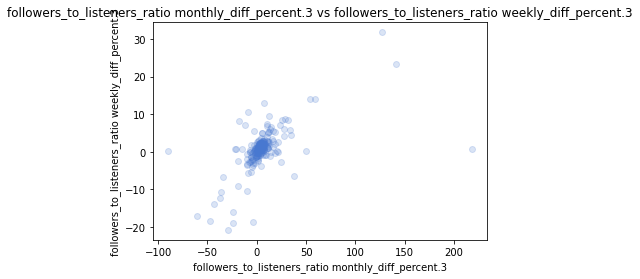

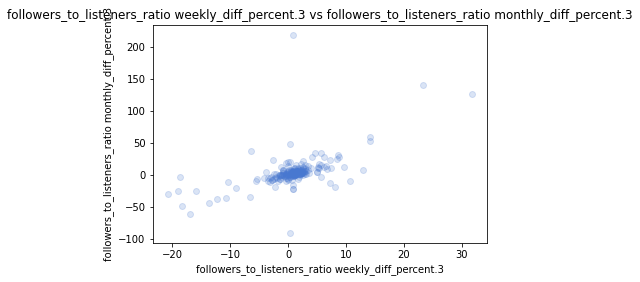

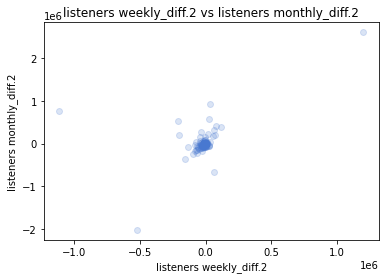

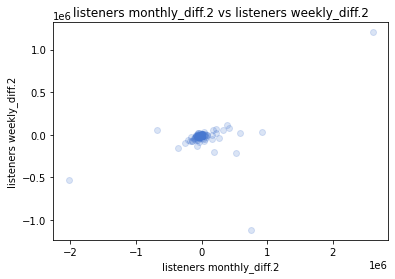

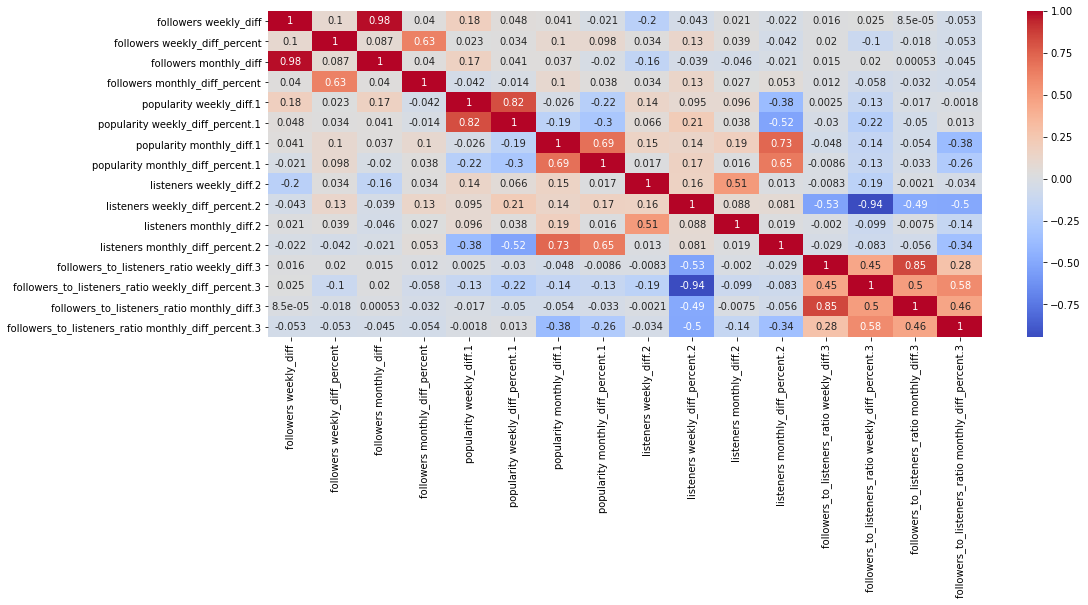

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


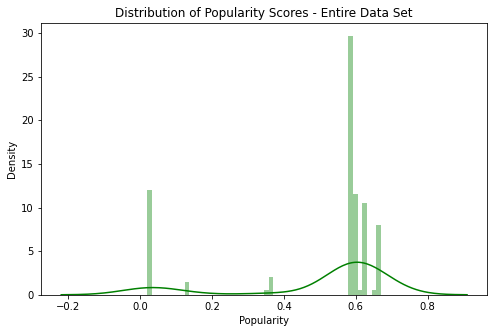

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


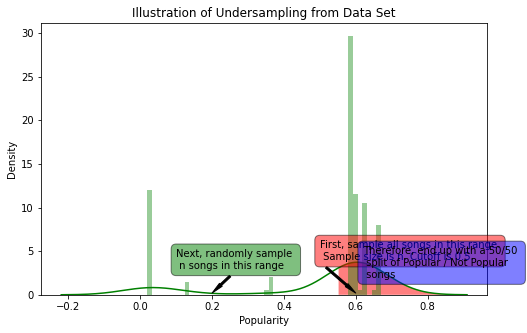

Mean value for followers feature for Popular artists: nan
Mean value for followers feature for Unpopular artists: 163243.60784313726
Mean value for listeners feature for Popular artists: nan
Mean value for listeners feature for Unpopular artists: 1325068.888888889


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

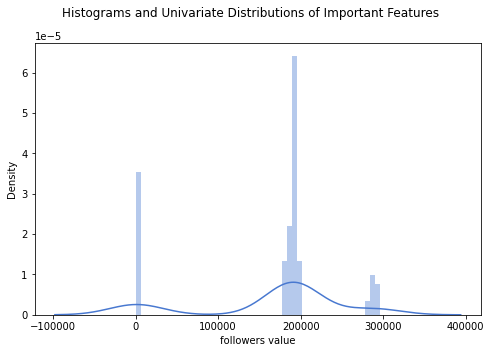

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

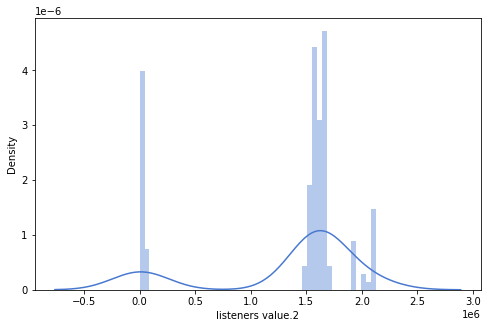

In [338]:
# prelim insights
statsgrp = get_df_info(grp)
statsgrp_std = get_df_info(grp_std)
statsgrp_norm = get_df_info(grp_norm)
statsgrp_stdnorm = get_df_info(grp_stdnorm)
stats_artist_diff = get_df_info(artist_diff)
get_stats(grp)
print()
corr_list,corr_data = calc_correlations(artist_diff)
plot_index = corr_list[corr_list > 0.5].index
for plot in plot_index:
  scatter_plot(artist_diff,plot[0],plot[1])
describe = describe_cols(artist_diff,10)
print()
plot_heatmap(artist_diff)
plot_pop_dist(grp)
undersample_plot(grp)
plot_univ_dists(grp, 70)

The top absolute correlations are:
followers weekly_diff                               followers monthly_diff                                 0.979722
listeners weekly_diff_percent.2                     followers_to_listeners_ratio weekly_diff_percent.3     0.942548
followers_to_listeners_ratio weekly_diff.3          followers_to_listeners_ratio monthly_diff.3            0.847196
popularity weekly_diff.1                            popularity weekly_diff_percent.1                       0.820303
popularity monthly_diff.1                           listeners monthly_diff_percent.2                       0.728152
                                                    popularity monthly_diff_percent.1                      0.689966
popularity monthly_diff_percent.1                   listeners monthly_diff_percent.2                       0.651418
followers weekly_diff_percent                       followers monthly_diff_percent                         0.626149
followers_to_listeners_ratio weekly_d

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


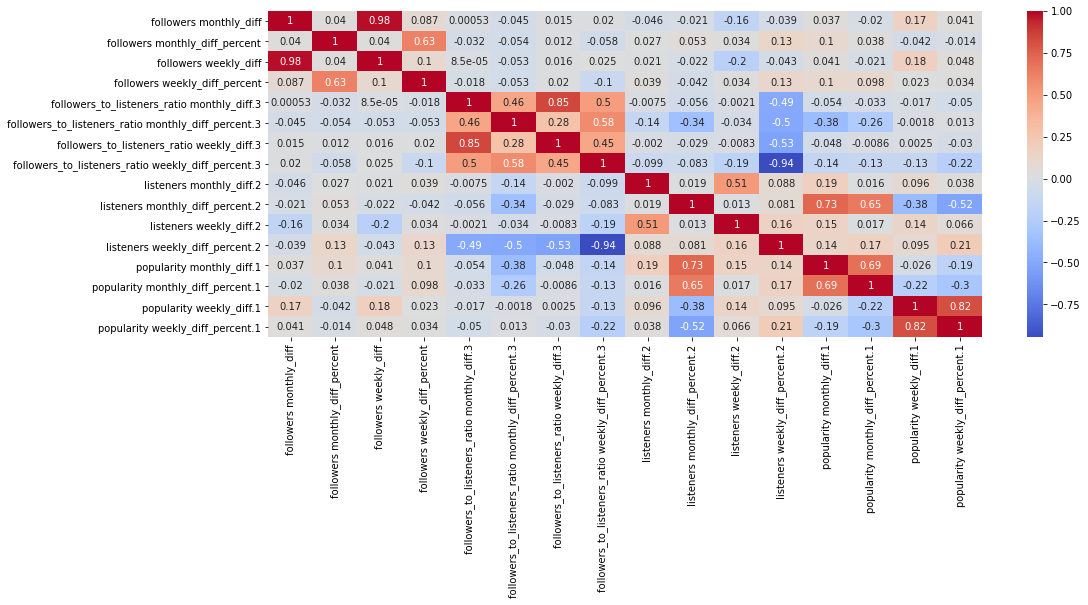

In [339]:
# Data prep
au_corr = get_top_abs_correlations(artist_diff, 25)
train_cols = np.unique((np.asarray([(index[0],index[1]) for index in au_corr.index])).flatten())
dtrain = artist_diff[train_cols]
dtrain.fillna(dtrain.mean(),inplace=True)
plot_heatmap(dtrain)
    

                              OLS Regression Results                              
Dep. Variable:     followers monthly_diff   R-squared:                       0.972
Model:                                OLS   Adj. R-squared:                  0.969
Method:                     Least Squares   F-statistic:                     404.3
Date:                    Wed, 09 Dec 2020   Prob (F-statistic):          1.06e-127
Time:                            14:42:54   Log-Likelihood:                -1791.7
No. Observations:                     192   AIC:                             3615.
Df Residuals:                         176   BIC:                             3667.
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

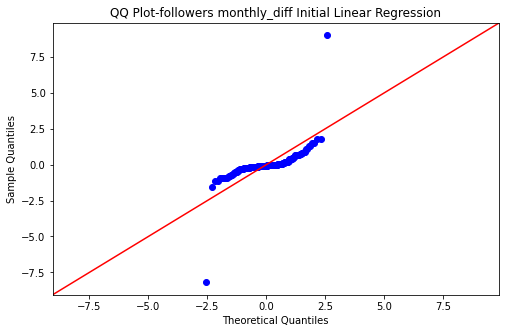

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


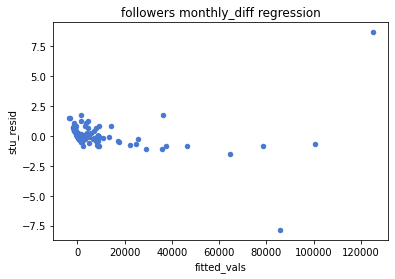

                                  OLS Regression Results                                  
Dep. Variable:     followers monthly_diff_percent   R-squared:                       0.470
Model:                                        OLS   Adj. R-squared:                  0.425
Method:                             Least Squares   F-statistic:                     10.40
Date:                            Wed, 09 Dec 2020   Prob (F-statistic):           1.37e-17
Time:                                    14:42:55   Log-Likelihood:                -323.16
No. Observations:                             192   AIC:                             678.3
Df Residuals:                                 176   BIC:                             730.4
Df Model:                                      15                                         
Covariance Type:                        nonrobust                                         
                                                          coef    std err          t      

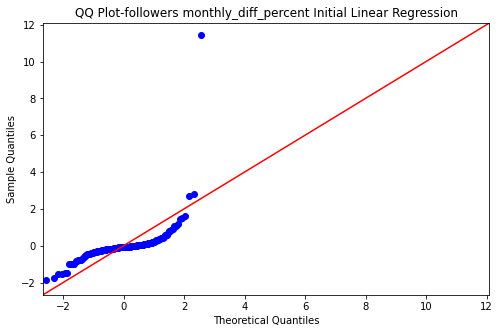

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


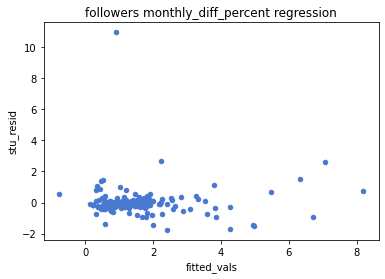

                              OLS Regression Results                             
Dep. Variable:     followers weekly_diff   R-squared:                       0.986
Model:                               OLS   Adj. R-squared:                  0.985
Method:                    Least Squares   F-statistic:                     810.4
Date:                   Wed, 09 Dec 2020   Prob (F-statistic):          1.09e-153
Time:                           14:42:55   Log-Likelihood:                -1440.4
No. Observations:                    192   AIC:                             2913.
Df Residuals:                        176   BIC:                             2965.
Df Model:                             15                                         
Covariance Type:               nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

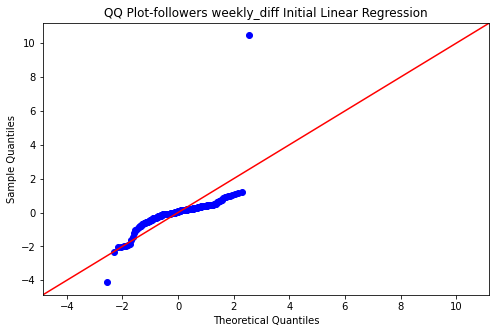

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


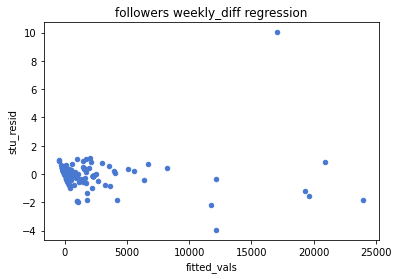

                                  OLS Regression Results                                 
Dep. Variable:     followers weekly_diff_percent   R-squared:                       0.434
Model:                                       OLS   Adj. R-squared:                  0.386
Method:                            Least Squares   F-statistic:                     9.010
Date:                           Wed, 09 Dec 2020   Prob (F-statistic):           2.49e-15
Time:                                   14:42:56   Log-Likelihood:                -14.020
No. Observations:                            192   AIC:                             60.04
Df Residuals:                                176   BIC:                             112.2
Df Model:                                     15                                         
Covariance Type:                       nonrobust                                         
                                                          coef    std err          t      P>|t|     

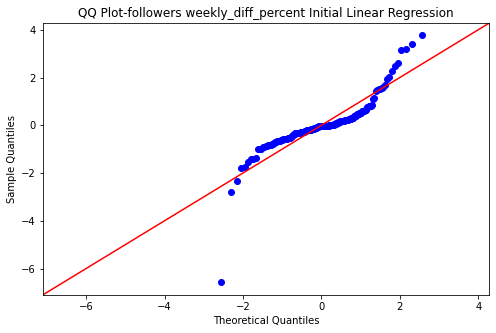

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


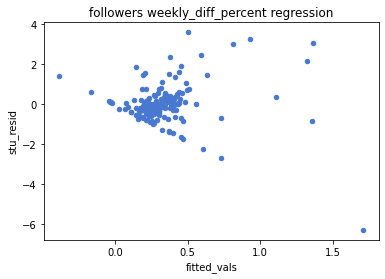

                                         OLS Regression Results                                        
Dep. Variable:     followers_to_listeners_ratio monthly_diff.3   R-squared:                       0.867
Model:                                                     OLS   Adj. R-squared:                  0.855
Method:                                          Least Squares   F-statistic:                     76.27
Date:                                         Wed, 09 Dec 2020   Prob (F-statistic):           1.20e-68
Time:                                                 14:42:56   Log-Likelihood:                -146.31
No. Observations:                                          192   AIC:                             324.6
Df Residuals:                                              176   BIC:                             376.7
Df Model:                                                   15                                         
Covariance Type:                                     nonrobust  

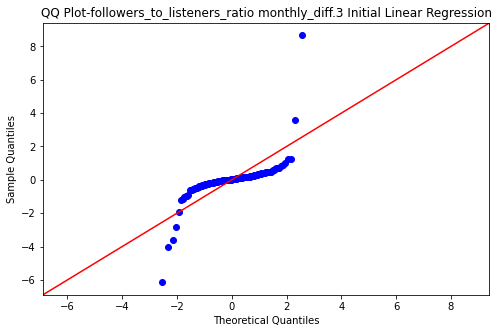

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


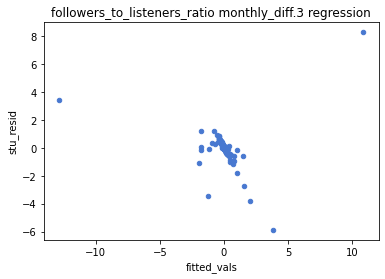

                                             OLS Regression Results                                            
Dep. Variable:     followers_to_listeners_ratio monthly_diff_percent.3   R-squared:                       0.557
Model:                                                             OLS   Adj. R-squared:                  0.519
Method:                                                  Least Squares   F-statistic:                     14.75
Date:                                                 Wed, 09 Dec 2020   Prob (F-statistic):           5.49e-24
Time:                                                         14:42:56   Log-Likelihood:                -813.42
No. Observations:                                                  192   AIC:                             1659.
Df Residuals:                                                      176   BIC:                             1711.
Df Model:                                                           15                                  

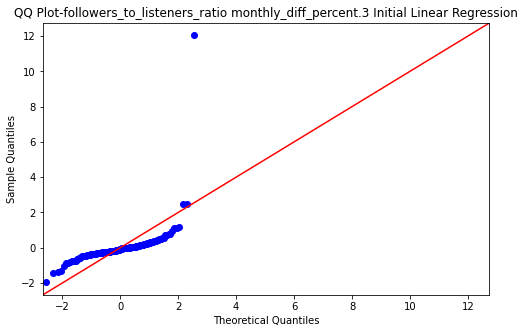

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


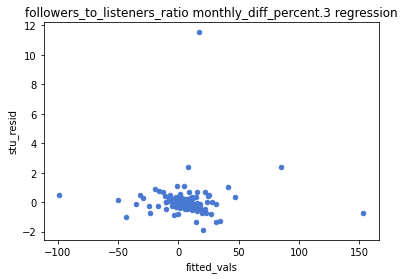

                                        OLS Regression Results                                        
Dep. Variable:     followers_to_listeners_ratio weekly_diff.3   R-squared:                       0.856
Model:                                                    OLS   Adj. R-squared:                  0.844
Method:                                         Least Squares   F-statistic:                     70.01
Date:                                        Wed, 09 Dec 2020   Prob (F-statistic):           7.36e-66
Time:                                                14:42:57   Log-Likelihood:                -36.265
No. Observations:                                         192   AIC:                             104.5
Df Residuals:                                             176   BIC:                             156.7
Df Model:                                                  15                                         
Covariance Type:                                    nonrobust            

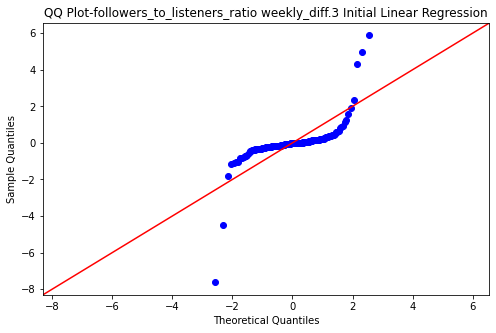

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


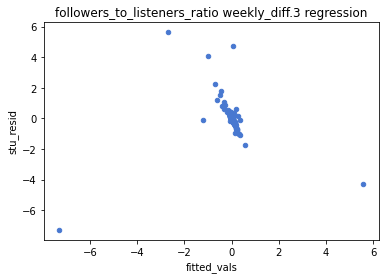

                                            OLS Regression Results                                            
Dep. Variable:     followers_to_listeners_ratio weekly_diff_percent.3   R-squared:                       0.940
Model:                                                            OLS   Adj. R-squared:                  0.935
Method:                                                 Least Squares   F-statistic:                     182.9
Date:                                                Wed, 09 Dec 2020   Prob (F-statistic):           9.23e-99
Time:                                                        14:42:57   Log-Likelihood:                -324.02
No. Observations:                                                 192   AIC:                             680.0
Df Residuals:                                                     176   BIC:                             732.2
Df Model:                                                          15                                         
C

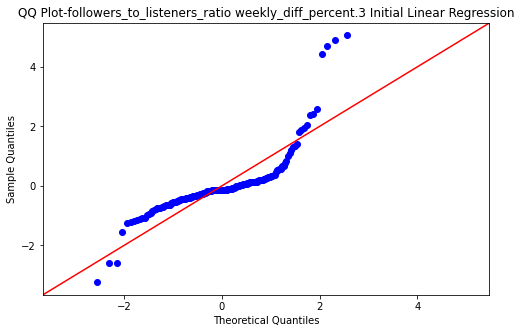

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


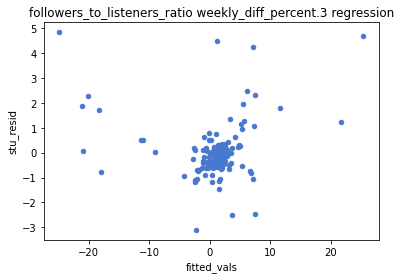

                               OLS Regression Results                               
Dep. Variable:     listeners monthly_diff.2   R-squared:                       0.558
Model:                                  OLS   Adj. R-squared:                  0.520
Method:                       Least Squares   F-statistic:                     14.81
Date:                      Wed, 09 Dec 2020   Prob (F-statistic):           4.61e-24
Time:                              14:42:57   Log-Likelihood:                -2594.4
No. Observations:                       192   AIC:                             5221.
Df Residuals:                           176   BIC:                             5273.
Df Model:                                15                                         
Covariance Type:                  nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

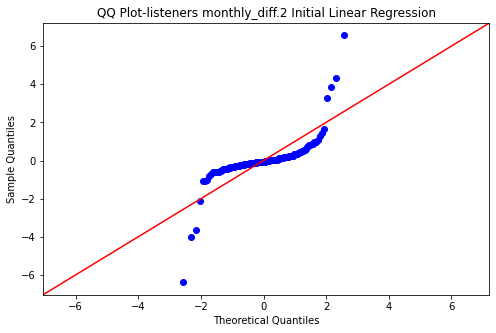

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


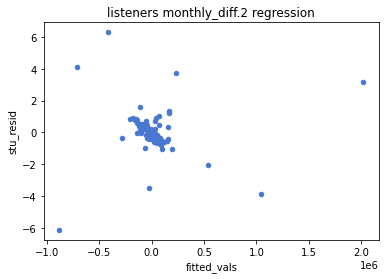

                                   OLS Regression Results                                   
Dep. Variable:     listeners monthly_diff_percent.2   R-squared:                       0.776
Model:                                          OLS   Adj. R-squared:                  0.757
Method:                               Least Squares   F-statistic:                     40.61
Date:                              Wed, 09 Dec 2020   Prob (F-statistic):           4.20e-49
Time:                                      14:42:58   Log-Likelihood:                -723.21
No. Observations:                               192   AIC:                             1478.
Df Residuals:                                   176   BIC:                             1531.
Df Model:                                        15                                         
Covariance Type:                          nonrobust                                         
                                                          coef    std 

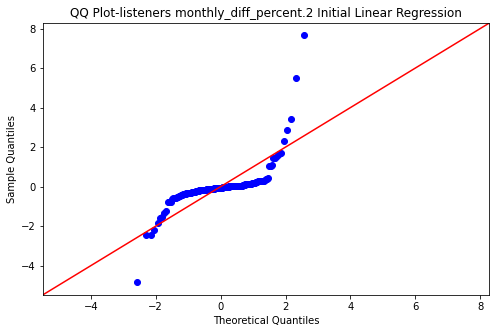

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


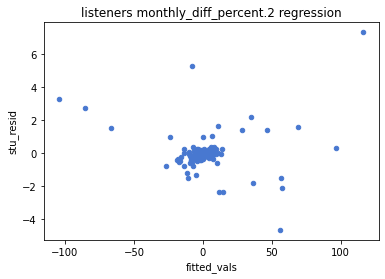

                               OLS Regression Results                              
Dep. Variable:     listeners weekly_diff.2   R-squared:                       0.573
Model:                                 OLS   Adj. R-squared:                  0.537
Method:                      Least Squares   F-statistic:                     15.76
Date:                     Wed, 09 Dec 2020   Prob (F-statistic):           2.50e-25
Time:                             14:42:58   Log-Likelihood:                -2448.2
No. Observations:                      192   AIC:                             4928.
Df Residuals:                          176   BIC:                             4980.
Df Model:                               15                                         
Covariance Type:                 nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

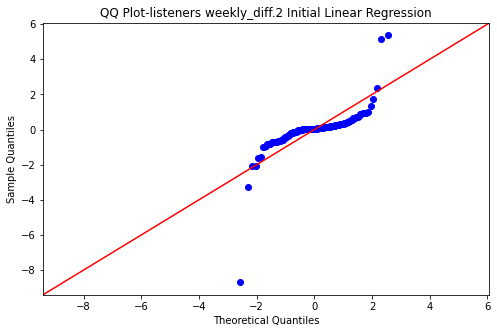

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


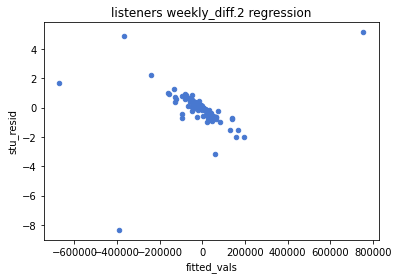

                                   OLS Regression Results                                  
Dep. Variable:     listeners weekly_diff_percent.2   R-squared:                       0.938
Model:                                         OLS   Adj. R-squared:                  0.933
Method:                              Least Squares   F-statistic:                     177.0
Date:                             Wed, 09 Dec 2020   Prob (F-statistic):           1.36e-97
Time:                                     14:42:59   Log-Likelihood:                -371.86
No. Observations:                              192   AIC:                             775.7
Df Residuals:                                  176   BIC:                             827.8
Df Model:                                       15                                         
Covariance Type:                         nonrobust                                         
                                                          coef    std err       

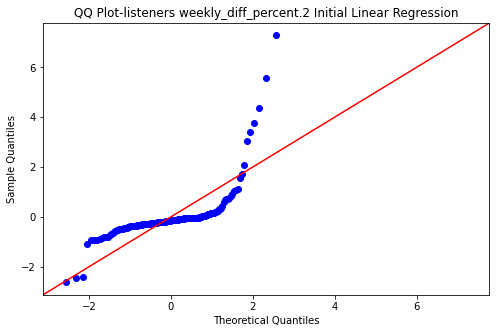

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


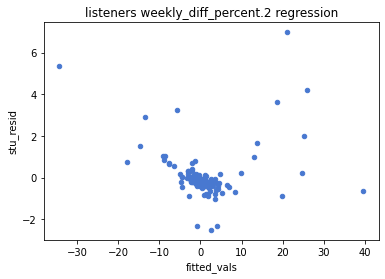

                                OLS Regression Results                               
Dep. Variable:     popularity monthly_diff.1   R-squared:                       0.807
Model:                                   OLS   Adj. R-squared:                  0.790
Method:                        Least Squares   F-statistic:                     48.91
Date:                       Wed, 09 Dec 2020   Prob (F-statistic):           1.28e-54
Time:                               14:42:59   Log-Likelihood:                -130.88
No. Observations:                        192   AIC:                             293.8
Df Residuals:                            176   BIC:                             345.9
Df Model:                                 15                                         
Covariance Type:                   nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------

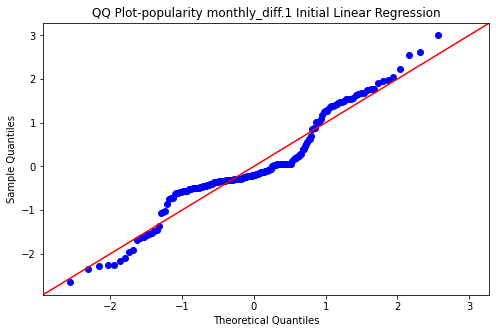

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


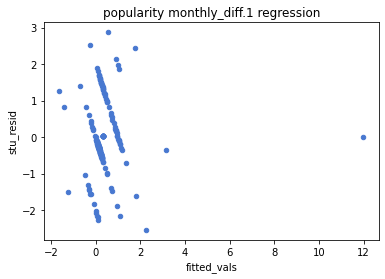

                                    OLS Regression Results                                   
Dep. Variable:     popularity monthly_diff_percent.1   R-squared:                       0.692
Model:                                           OLS   Adj. R-squared:                  0.666
Method:                                Least Squares   F-statistic:                     26.41
Date:                               Wed, 09 Dec 2020   Prob (F-statistic):           2.55e-37
Time:                                       14:42:59   Log-Likelihood:                -707.06
No. Observations:                                192   AIC:                             1446.
Df Residuals:                                    176   BIC:                             1498.
Df Model:                                         15                                         
Covariance Type:                           nonrobust                                         
                                                          co

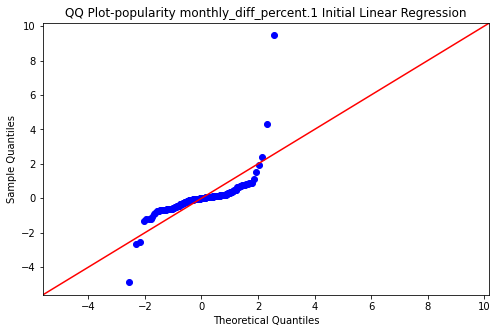

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


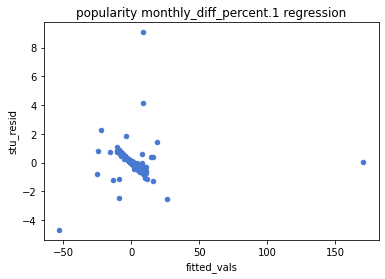

                               OLS Regression Results                               
Dep. Variable:     popularity weekly_diff.1   R-squared:                       0.737
Model:                                  OLS   Adj. R-squared:                  0.715
Method:                       Least Squares   F-statistic:                     32.89
Date:                      Wed, 09 Dec 2020   Prob (F-statistic):           3.81e-43
Time:                              14:43:00   Log-Likelihood:                 62.890
No. Observations:                       192   AIC:                            -93.78
Df Residuals:                           176   BIC:                            -41.66
Df Model:                                15                                         
Covariance Type:                  nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

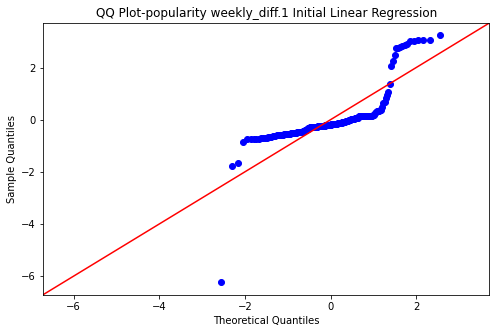

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


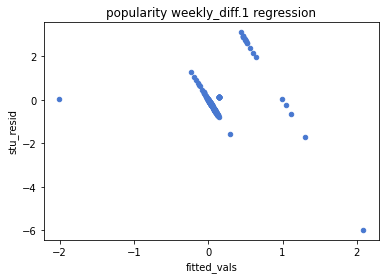

                                   OLS Regression Results                                   
Dep. Variable:     popularity weekly_diff_percent.1   R-squared:                       0.785
Model:                                          OLS   Adj. R-squared:                  0.766
Method:                               Least Squares   F-statistic:                     42.76
Date:                              Wed, 09 Dec 2020   Prob (F-statistic):           1.31e-50
Time:                                      14:43:00   Log-Likelihood:                -137.55
No. Observations:                               192   AIC:                             307.1
Df Residuals:                                   176   BIC:                             359.2
Df Model:                                        15                                         
Covariance Type:                          nonrobust                                         
                                                          coef    std 

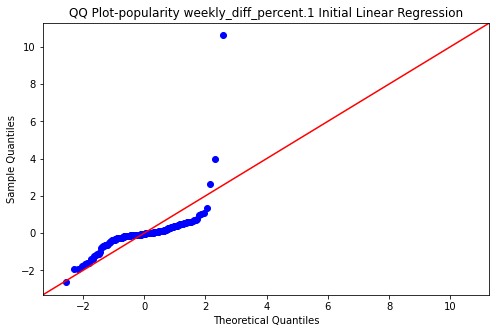

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


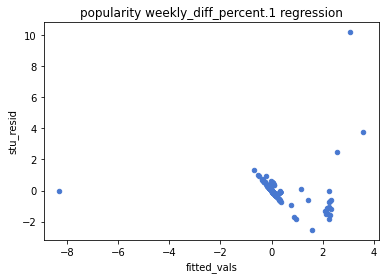

KeyError: ignored

In [340]:
# regression
linear_regression_initial(dtrain)
basic_logistic_regression(artist_diff)

In [ ]:
import os 
import psutil

process = psutil.Process(os.getpid())
process.memory_info()


In [ ]:
import resource
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

In [ ]:
!unzip 266_Erick\ Morillo.zip -d path_to_directory

In [ ]:
import glob
import pandas as pd

# get data file names
path =r'/content/path_to_directory'
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)

In [ ]:
big_frame.to_csv("Chartmetric_Sample_Data.csv")